<a href="https://colab.research.google.com/github/MauriceLaf/CAP4630/blob/master/HW4_Pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW 4 #3 Pt 1


**To aid with grading, I have made new comments that I have added about data/decisions for classifiers in bold**



## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 20:00:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  82.6MB/s    in 0.8s    

2020-04-21 20:00:19 (82.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with MobileNetV2 convolution base and add classifier layers

**I chose MobileNetV2 because of a source I found that both used MobileNetV2 and provided a good explanation of the uses of convolutionial bases as well as fine-tuning pre-trained models.** SOURCE: https://www.tensorflow.org/tutorials/images/transfer_learning 

### Load the convolutional base

In [0]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected classifier layers

**First of the two choices I went through was the already implemented densely connected classifier layers that used a flatten and a large dense layer as the classifiers. The densely connected classifier layers have a much better initial result than the GlobalAveragePooling2D classifier. This will be visible upon the initial training without the training of the conv_base.**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8192256   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 10,450,497
Trainable params: 8,192,513
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 19s 193ms/step - loss: 0.4148 - acc: 0.8095 - val_loss: 0.0503 - val_acc: 0.9430
Epoch 2/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3065 - acc: 0.8665 - val_loss: 0.2682 - val_acc: 0.9080
Epoch 3/30
100/100 [==============================] - 16s 164ms/step - loss: 0.2962 - acc: 0.8700 - val_loss: 0.1853 - val_acc: 0.9020
Epoch 4/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3050 - acc: 0.8725 - val_loss: 0.2642 - val_acc: 0.9020
Epoch 5/30
100/100 [==============================] - 17s 165ms/step - loss: 0.2784 - acc: 0.8845 - val_loss: 0.0209 - val_acc: 0.8510
Epoch 6/30
100/100 [==============================] - 17s 165ms/step - loss: 0.2525 - acc: 0.8925 - val_loss: 0.0077 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 16s 164ms/step - loss: 0.2572 - acc: 0.8920 - val_lo

**From these results it is clear that the loss and accuracy of the dense connected layer are both much better than that of the GlobalAveragePooling2D layer.
.1838 compared to ~.22
92.75% compared to 82.35%**

## Display curves of loss and accuracy during training

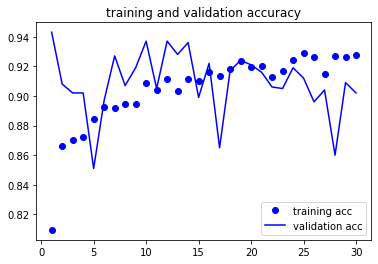

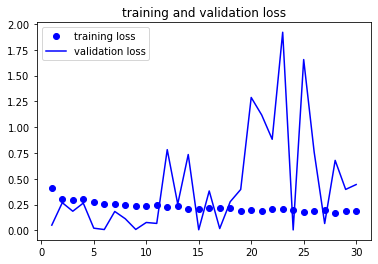

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**The loss and accuracy curves show an initially low and lowly decreasing loss as well as an initially high and slowly increasing accuracy, but there are signs of overfitting already with the validation jumps being quite intense**

## Fine-tuning

**For MobileNetV2, fine tuning the upper layers allows us to retrain the non-generalize image reading layers and the more specific layers to recognize cats and dogs. The lower a layer is, the more general it is, and the higher a layer is, the more specific it is.**

**I selected the first 105 layers to fine tune**

**Source: https://www.tensorflow.org/tutorials/images/transfer_learning**

In [0]:
conv_base.trainable = True

print("Number of layers in the base model: ", len(conv_base.layers))

# Fine-tune from this layer onwards
fine_tune_at = 105

# Freeze all layers below the 50th to the bottom layer
for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 236ms/step - loss: 0.0452 - acc: 0.9835 - val_loss: 0.0964 - val_acc: 0.9540
Epoch 2/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0484 - acc: 0.9820 - val_loss: 0.3413 - val_acc: 0.9520
Epoch 3/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0287 - acc: 0.9870 - val_loss: 0.3105 - val_acc: 0.9520
Epoch 4/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0517 - acc: 0.9825 - val_loss: 0.0102 - val_acc: 0.9460
Epoch 5/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0348 - acc: 0.9875 - val_loss: 6.1747e-04 - val_acc: 0.9520
Epoch 6/100
100/100 [==============================] - 17s 175ms/step - loss: 0.0487 - acc: 0.9830 - val_loss: 0.1261 - val_acc: 0.9530
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0378 - acc: 0.9865 - val_loss: 0.0624 - val_acc: 0.9480
Epoch 8/100
100/100 [=======================

## Display learning curves during fine-tuning

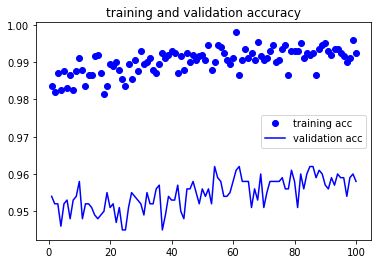

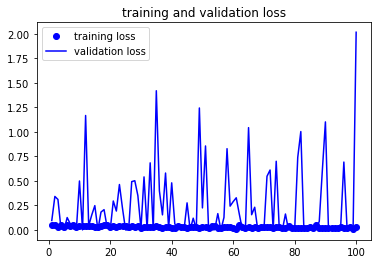

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)